## PeerHive V2

### PeerHive V2:Sprint Kick-off 🔥

#### Imports📚

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression # For Platt Scaling


### Day2:  The "Brains" 🧠: Cross-Attention Block

In [5]:
class CrossAttentionBlock(nn.Module):
    """A single block of T->I and I->T cross-attention."""
    def __init__(self, d_text, d_image, n_heads=8):
        super().__init__()
        # Text queries, Image keys/values (T->I)
        self.text_to_image_attn = nn.MultiheadAttention(
            embed_dim=d_text, num_heads=n_heads, kdim=d_image, vdim=d_image, batch_first=True
        )
        # Image queries, Text keys/values (I->T)
        self.image_to_text_attn = nn.MultiheadAttention(
            embed_dim=d_image, num_heads=n_heads, kdim=d_text, vdim=d_text, batch_first=True
        )
        # Simple feed-forward networks for refinement
        self.ffn_text = nn.Linear(d_text, d_text)
        self.ffn_image = nn.Linear(d_image, d_image)

    def forward(self, text_embeds, image_embeds):
        # --- Text attends to Image ---
        attended_text, _ = self.text_to_image_attn(text_embeds, image_embeds, image_embeds)
        
        # --- Image attends to Text ---
        attended_image, _ = self.image_to_text_attn(image_embeds, text_embeds, text_embeds)

        # Refine and return
        refined_text = self.ffn_text(attended_text)
        refined_image = self.ffn_image(attended_image)
        
        return refined_text, refined_image

#### Test Script

In [3]:
import torch
import torch.nn as nn

# --- The Class from Yesterday ---
class CrossAttentionBlock(nn.Module):
    """A single block of T->I and I->T cross-attention."""
    def __init__(self, d_text, d_image, n_heads=8):
        super().__init__()
        # Text queries, Image keys/values (T->I)
        self.text_to_image_attn = nn.MultiheadAttention(
            embed_dim=d_text, num_heads=n_heads, kdim=d_image, vdim=d_image, batch_first=True
        )
        # Image queries, Text keys/values (I->T)
        self.image_to_text_attn = nn.MultiheadAttention(
            embed_dim=d_image, num_heads=n_heads, kdim=d_text, vdim=d_text, batch_first=True
        )
        # Simple feed-forward networks for refinement
        self.ffn_text = nn.Linear(d_text, d_text)
        self.ffn_image = nn.Linear(d_image, d_image)

    def forward(self, text_embeds, image_embeds):
        # --- Text attends to Image ---
        attended_text, _ = self.text_to_image_attn(text_embeds, image_embeds, image_embeds)
        
        # --- Image attends to Text ---
        attended_image, _ = self.image_to_text_attn(image_embeds, text_embeds, text_embeds)

        # Refine and return
        refined_text = self.ffn_text(attended_text)
        refined_image = self.ffn_image(attended_image)
        
        return refined_text, refined_image

# --- The Sanity Check ---
if __name__ == "__main__":
    # --- Configuration ---
    BATCH_SIZE = 16  # How many posts to process at once
    
    # Text: Pretend DistilBERT gives us 30 tokens, each 768-dim
    TEXT_TOKENS = 30
    TEXT_DIM = 768
    
    # Image: Pretend CLIP gives us 50 patches, each 512-dim
    IMAGE_PATCHES = 50
    IMAGE_DIM = 512

    # --- Dummy Data ---
    dummy_text_embeddings = torch.randn(BATCH_SIZE, TEXT_TOKENS, TEXT_DIM)
    dummy_image_embeddings = torch.randn(BATCH_SIZE, IMAGE_PATCHES, IMAGE_DIM)
    
    print("--- INPUT SHAPES ---")
    print(f"Text Embeddings:  {dummy_text_embeddings.shape}")
    print(f"Image Embeddings: {dummy_image_embeddings.shape}\n")

    # --- Model Instantiation & Forward Pass ---
    model = CrossAttentionBlock(d_text=TEXT_DIM, d_image=IMAGE_DIM, n_heads=8)
    refined_text, refined_image = model(dummy_text_embeddings, dummy_image_embeddings)

    # --- Verification ---
    print("--- OUTPUT SHAPES ---")
    print(f"Refined Text:     {refined_text.shape}")
    print(f"Refined Image:    {refined_image.shape}\n")

    # --- Conclusion ---
    if (refined_text.shape == dummy_text_embeddings.shape and 
        refined_image.shape == dummy_image_embeddings.shape):
        print("✅ SUCCESS: Input and output shapes match perfectly. The block is working!")
    else:
        print("❌ FAILURE: Shape mismatch detected.")

--- INPUT SHAPES ---
Text Embeddings:  torch.Size([16, 30, 768])
Image Embeddings: torch.Size([16, 50, 512])

--- OUTPUT SHAPES ---
Refined Text:     torch.Size([16, 30, 768])
Refined Image:    torch.Size([16, 50, 512])

✅ SUCCESS: Input and output shapes match perfectly. The block is working!


### Day 3:The Full Assembly 🏗️: Building the `FusionModel`

We're wrapping our CrossAttentionBlock in a complete FusionModel. This model will take in the raw embeddings, work its cross-attention magic, and then make a final prediction about the burnout zone.

    Step 1: The embeddings go into the CrossAttentionBlock.

    Step 2: We pool the refined outputs to create a single summary vector for each modality.

    Step 3: We concatenate them into the almighty z_fused vector.

    Step 4: We pass z_fused to our final classification head to get the burnout scores!

In [6]:
class FusionModel(nn.Module):
    """
    The full fusion model.
    Wraps the CrossAttentionBlock and adds a classification head.
    """
    def __init__(self, d_text, d_image, d_fusion=512, n_heads=8, n_classes=4):
        super().__init__()
        self.cross_attention = CrossAttentionBlock(d_text, d_image, n_heads)
        
        # The MLP head that takes the fused vector and classifies it
        self.fusion_head = nn.Sequential(
            nn.Linear(d_text + d_image, d_fusion),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_fusion, n_classes)
        )

    def forward(self, text_embeds, image_embeds):
        # 1. Get refined embeddings from the cross-attention block
        refined_text, refined_image = self.cross_attention(text_embeds, image_embeds)
        
        # 2. Pool the outputs to get a single vector for each modality
        pooled_text = refined_text.mean(dim=1)
        pooled_image = refined_image.mean(dim=1)
        
        # 3. Concatenate to create the fused vector
        z_fused = torch.cat([pooled_text, pooled_image], dim=1)
        
        # 4. Pass through the classification head to get logits
        logits = self.fusion_head(z_fused)
        
        return logits

#### The Moment of Truth ✅: A Mini Training Loop Sanity Check

This is it! We'll run a single, simulated training step. This isn't about getting good results yet; it's about proving that our entire contraption works without exploding. We need to see data flow from end to end, a loss value get calculated, and the model's weights get updated. No errors, no excuses!

In [7]:
# --- Configuration ---
BATCH_SIZE = 16
TEXT_TOKENS = 30
TEXT_DIM = 768
IMAGE_PATCHES = 50
IMAGE_DIM = 512
NUM_CLASSES = 4 # calm, stressed, overwhelmed, burned_out

# --- Dummy Data ---
# Input embeddings
dummy_text = torch.randn(BATCH_SIZE, TEXT_TOKENS, TEXT_DIM)
dummy_image = torch.randn(BATCH_SIZE, IMAGE_PATCHES, IMAGE_DIM)
# Target labels (random integers from 0 to 3)
dummy_labels = torch.randint(0, NUM_CLASSES, (BATCH_SIZE,))

print("--- 📥 INPUTS 📥 ---")
print(f"Text Batch Shape:  {dummy_text.shape}")
print(f"Image Batch Shape: {dummy_image.shape}")
print(f"Labels Batch Shape: {dummy_labels.shape}\n")

# --- Model, Loss, and Optimizer ---
model = FusionModel(d_text=TEXT_DIM, d_image=IMAGE_DIM, n_classes=NUM_CLASSES)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# --- ⚙️ A SINGLE TRAINING STEP ⚙️ ---
print("--- TRAINING STEP ---")
# 1. Zero out gradients
optimizer.zero_grad()
# 2. Forward pass: get model predictions (logits)
logits = model(dummy_text, dummy_image)
# 3. Calculate the loss
loss = loss_fn(logits, dummy_labels)
# 4. Backward pass: compute gradients
loss.backward()
# 5. Update the model's weights
optimizer.step()




--- 📥 INPUTS 📥 ---
Text Batch Shape:  torch.Size([16, 30, 768])
Image Batch Shape: torch.Size([16, 50, 512])
Labels Batch Shape: torch.Size([16])

--- TRAINING STEP ---


#### --- 📈 VERIFICATION 📈 ---

In [8]:
print("\n--- VERIFICATION ---")
print(f"Output Logits Shape: {logits.shape}")
print(f"Calculated Loss: {loss.item():.4f}")

if logits.shape == (BATCH_SIZE, NUM_CLASSES) and loss.item() > 0:
    print("\n✅ SUCCESS: The model completed a training step without errors!")
    print("Shapes are correct, loss was calculated, and weights were updated.")
else:
    print("\n❌ FAILURE: Something went wrong during the training step.")


--- VERIFICATION ---
Output Logits Shape: torch.Size([16, 4])
Calculated Loss: 1.3850

✅ SUCCESS: The model completed a training step without errors!
Shapes are correct, loss was calculated, and weights were updated.


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print(device)

cuda


### Day 4:The "Time Machine" ⏳: Building the SequenceDataset

This is the main event for Day 4. We're creating a custom PyTorch Dataset. This class is a bit of a beast, but it's the magic that turns our raw data into perfectly formatted batches for the GRU/LSTM.

In [9]:
class SequenceDataset(Dataset):
    """
    Custom PyTorch Dataset for user post sequences.
    Groups posts by user, pads them to a fixed length, and creates an attention mask.
    """
    def __init__(self, csv_file, max_seq_len=20):
        self.df = pd.read_csv(csv_file)
        self.max_seq_len = max_seq_len
        
        # We need a user_id column to group by!
        self.df['user_id'] = np.where(
            self.df['source'] == 'flickr', 
            'flickr_' + self.df['image_path'].str.split('\\\\').str[-1],
            'memotion_' + self.df['image_path'].str.split('\\\\').str[-1]
        )
        
        # --- THIS IS THE CORRECTED LINE ---
        # We iterate through the groupby object to create a list of DataFrames.
        self.users = [group_df for _, group_df in self.df.groupby('user_id')]
        self.user_ids = self.df['user_id'].unique()

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        user_df = self.users[idx]
        seq_len = len(user_df)

        # --- FAKE DATA (for now) ---
        D_FUSED = 512
        z_fused_sequence = torch.randn(seq_len, D_FUSED)
        labels = torch.randint(0, 4, (seq_len,))

        # --- Padding & Masking ---
        padded_sequence = torch.zeros(self.max_seq_len, D_FUSED)
        padded_labels = torch.full((self.max_seq_len,), -100)
        len_to_copy = min(seq_len, self.max_seq_len)
        
        padded_sequence[:len_to_copy] = z_fused_sequence[:len_to_copy]
        padded_labels[:len_to_copy] = labels[:len_to_copy]

        attention_mask = torch.zeros(self.max_seq_len, dtype=torch.float)
        attention_mask[:len_to_copy] = 1.0
        
        return {
            "sequence": padded_sequence,
            "targets": padded_labels,
            "mask": attention_mask
        }

#### Sanity Check ✅: Testing the DataLoader

In [10]:
CSV_PATH = "fusion_dataset_with_clip.csv"
MAX_SEQ_LEN = 20
BATCH_SIZE = 8

# --- Instantiate Dataset and DataLoader ---
sequence_dataset = SequenceDataset(csv_file=CSV_PATH, max_seq_len=MAX_SEQ_LEN)
dataloader = DataLoader(sequence_dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- Pull one batch ---
one_batch = next(iter(dataloader))

# --- Verification ---
print("--- BATCH SHAPES ---")
print(f"Sequence shape: {one_batch['sequence'].shape}")
print(f"Labels shape:   {one_batch['targets'].shape}")
print(f"Mask shape:     {one_batch['mask'].shape}\n")

# --- Conclusion ---
expected_seq_shape = (BATCH_SIZE, MAX_SEQ_LEN, 512)
if one_batch['sequence'].shape == expected_seq_shape:
    print("✅ SUCCESS: The DataLoader is producing correctly shaped batches!")
    print("We are officially ready to train the sequence model on Day 5.")
else:
    print(f"❌ FAILURE: Shape mismatch! Expected {expected_seq_shape} but got {one_batch['sequence'].shape}")

--- BATCH SHAPES ---
Sequence shape: torch.Size([8, 20, 512])
Labels shape:   torch.Size([8, 20])
Mask shape:     torch.Size([8, 20])

✅ SUCCESS: The DataLoader is producing correctly shaped batches!
We are officially ready to train the sequence model on Day 5.


### Day 5: 📈 The "Soul" Learns to See Patterns!

In [11]:
class SequenceModel(nn.Module):
    """
    A GRU-based model to predict a burnout risk score over a sequence of posts.
    """
    def __init__(self, input_dim=512, hidden_dim=256, n_layers=2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.2 if n_layers > 1 else 0
        )
        self.head = nn.Linear(hidden_dim, 1) # Predicts one number: the risk score

    def forward(self, sequence):
        # sequence shape: [batch_size, seq_len, input_dim]
        gru_output, _ = self.gru(sequence)
        # gru_output shape: [batch_size, seq_len, hidden_dim]
        
        # Pass the output of every timestep through the head
        predictions = self.head(gru_output).squeeze(-1) # Squeeze to remove the last dim
        # predictions shape: [batch_size, seq_len]
        
        return predictions

#### Sanity Check ✅: A Mini Training Loop for the "Soul"

In [13]:
# --- Configuration ---
CSV_PATH = "fusion_dataset_with_clip.csv"
MAX_SEQ_LEN = 20
BATCH_SIZE = 8
D_FUSED = 512
HIDDEN_DIM = 256

# --- Data ---
# We use the corrected SequenceDataset class from the previous fix
dataset = SequenceDataset(csv_file=CSV_PATH, max_seq_len=MAX_SEQ_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- Model, Loss, and Optimizer ---
class SequenceModel(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=256, n_layers=2):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=0.2 if n_layers > 1 else 0)
        self.head = nn.Linear(hidden_dim, 1)
    def forward(self, sequence):
        gru_output, _ = self.gru(sequence)
        predictions = self.head(gru_output).squeeze(-1)
        return predictions

model = SequenceModel(input_dim=D_FUSED, hidden_dim=HIDDEN_DIM)
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# --- Fetch one batch ---
batch = next(iter(dataloader))
sequences = batch["sequence"]
# --- THE FIX IS HERE ---
# We explicitly cast the targets and mask to the correct data types.
targets = batch["targets"].float() # <-- Ensure targets are float
mask = batch["mask"].float()       # <-- Ensure mask is also float for consistency

# --- A Single Training Step ---
print("--- ⚙️ TRAINING STEP ⚙️ ---")
optimizer.zero_grad()
predictions = model(sequences)

# --- MASKED LOSS CALCULATION ---
active_predictions = predictions[mask == 1]
active_targets = targets[mask == 1]
loss = loss_fn(active_predictions, active_targets)

loss.backward()
optimizer.step()

# --- 📈 VERIFICATION 📈 ---
print(f"\nPredictions Shape (Full): {predictions.shape}")
print(f"Targets Shape (Full):   {targets.shape}")
print(f"Mask Shape:             {mask.shape}\n")
print(f"Number of Active (Real) Points in Batch: {int(mask.sum())}")
print(f"Calculated Loss (on active points only): {loss.item():.4f}\n")

if loss.item() > 0:
    print("✅ SUCCESS: The sequence model completed a training step!")
    print("Data types are correct, and the model is learning.")
else:
    print("❌ FAILURE: Something went wrong.")

--- ⚙️ TRAINING STEP ⚙️ ---

Predictions Shape (Full): torch.Size([8, 20])
Targets Shape (Full):   torch.Size([8, 20])
Mask Shape:             torch.Size([8, 20])

Number of Active (Real) Points in Batch: 36
Calculated Loss (on active points only): 3.2920

✅ SUCCESS: The sequence model completed a training step!
Data types are correct, and the model is learning.


### Day 6: The "Reality Check" Day! ⚖️

#### Mission 1: Risk Calibration ⚖️

Our GRU model outputs raw scores (logits) that aren't true probabilities. Calibration is the process of mapping these scores to real, reliable probabilities.

##### Step 1: Get Raw Model Outputs

First, let's pretend we've run our trained SequenceModel on a validation set and collected all the active_predictions and active_targets.

In [14]:
# --- FAKE VALIDATION DATA (for demonstration) ---
# In a real scenario, these would be the outputs from running your trained Day 5 model
# on a held-out validation set.
np.random.seed(42)
raw_predictions = np.random.rand(1000) * 1.2 - 0.1 # Overconfident predictions
true_outcomes = (raw_predictions + np.random.randn(1000) * 0.2 > 0.6).astype(int)

# Clamp predictions to be within a valid range for probability inputs
raw_predictions = np.clip(raw_predictions, 0.01, 0.99)

##### Step 2: Calibrate with Isotonic Regression

Isotonic Regression is a powerful, non-parametric method. It finds the best possible step-function to remap our model's scores to true probabilities. It's great because it doesn't assume any specific shape for the calibration curve.

In [17]:
# --- Isotonic Regression ---
iso_reg = IsotonicRegression(y_min=0, y_max=1, out_of_bounds="clip")
iso_reg.fit(raw_predictions, true_outcomes)

# Get the calibrated probabilities
calibrated_iso = iso_reg.predict(raw_predictions)

print("--- Isotonic Regression ---")
print("First 5 raw scores:     ", raw_predictions[:5].round(3))
print("First 5 calibrated scores:", calibrated_iso[:5].round(3))

--- Isotonic Regression ---
First 5 raw scores:      [0.349 0.99  0.778 0.618 0.087]
First 5 calibrated scores: [0.173 0.99  0.862 0.682 0.   ]


##### Step 3: (Optional) Calibrate with Platt Scaling
Platt Scaling is simpler. It just fits a logistic regression model to map your model's output to a probability. It's faster but less flexible than Isotonic Regression.

In [18]:
# --- Platt Scaling (Logistic Regression) ---
platt_scaler = LogisticRegression()
# Scikit-learn's LogisticRegression needs a 2D array, so we reshape
platt_scaler.fit(raw_predictions.reshape(-1, 1), true_outcomes)

# Get the calibrated probabilities
calibrated_platt = platt_scaler.predict_proba(raw_predictions.reshape(-1, 1))[:, 1]

print("\n--- Platt Scaling ---")
print("First 5 raw scores:    ", raw_predictions[:5].round(3))
print("First 5 calibrated scores:", calibrated_platt[:5].round(3))


--- Platt Scaling ---
First 5 raw scores:     [0.349 0.99  0.778 0.618 0.087]
First 5 calibrated scores: [0.168 0.95  0.809 0.576 0.03 ]


#### Mission 2: Plotting Per-User Curves 📈

This is the fun part! We'll visualize our model's performance on a single, hypothetical user to see if it's capturing the trend correctly.

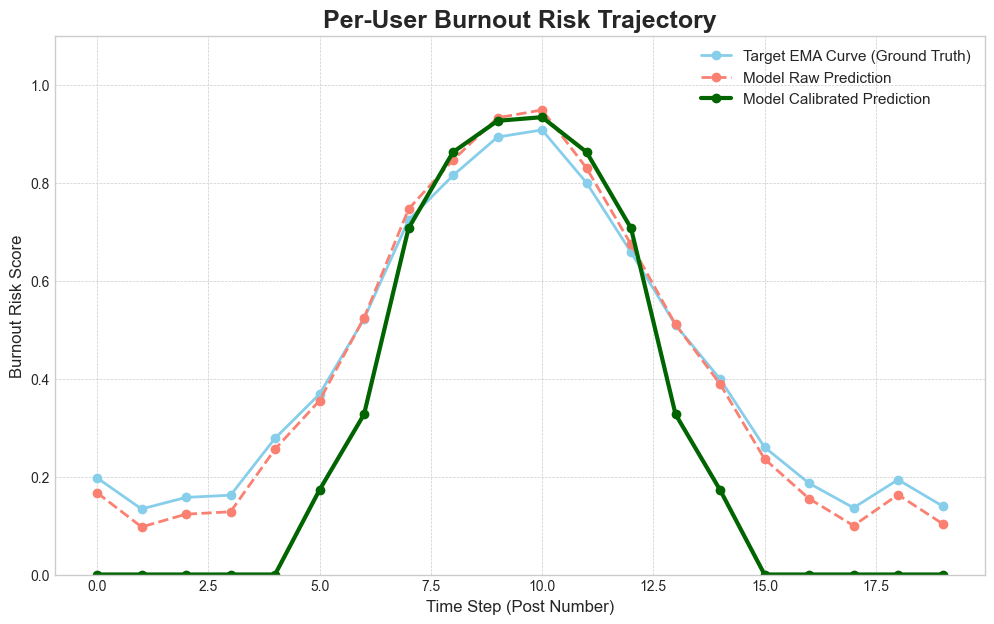

In [19]:
# --- FAKE USER DATA (for demonstration) ---
# Let's create a plausible story for one user over 20 posts
time_steps = np.arange(20)
# The "ground truth" EMA curve: starts low, spikes, then recovers
true_risk_curve = 0.1 + 0.8 * np.sin(time_steps / 6) ** 4 + np.random.rand(20) * 0.1
true_risk_curve = np.clip(true_risk_curve, 0, 1)

# The model's (uncalibrated) prediction: it captures the trend but is overconfident
model_prediction_curve = true_risk_curve * 1.1 - 0.05
model_prediction_curve = np.clip(model_prediction_curve, 0, 1)

# The model's (calibrated) prediction:
calibrated_prediction_curve = iso_reg.predict(model_prediction_curve)


# --- The Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(time_steps, true_risk_curve, 'o-', label='Target EMA Curve (Ground Truth)', color='skyblue', linewidth=2)
ax.plot(time_steps, model_prediction_curve, 'o--', label='Model Raw Prediction', color='salmon', linewidth=2)
ax.plot(time_steps, calibrated_prediction_curve, 'o-', label='Model Calibrated Prediction', color='darkgreen', linewidth=3)

ax.set_title('Per-User Burnout Risk Trajectory', fontsize=18, fontweight='bold')
ax.set_xlabel('Time Step (Post Number)', fontsize=12)
ax.set_ylabel('Burnout Risk Score', fontsize=12)
ax.set_ylim(0, 1.1)
ax.legend(fontsize=11)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()